In [ ]:
# A variable to switch between a smaller sample of trainnig data and actual training data.
TESTING = True

In [ ]:
import os
import xml.etree.ElementTree as et
import json
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as pp
from google.colab import drive
from tqdm.notebook import tqdm

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# A data structure that holds block of characters.
class PageBlock:
    def __init__(self, x1, y1, x2, y2, block_class='textRegion'):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.block_class = block_class

In [ ]:
# A utility function to remove margin
def shrink_to_best_fit(img, page_block):

    shrink_line = np.all(
        img[page_block.y1:page_block.y2+1, page_block.x1:page_block.x2+1] == 0,
        axis=1
    )

    shrink_col = np.all(
        img[page_block.y1:page_block.y2+1, page_block.x1:page_block.x2+1] == 0,
        axis=0
    )

    for val in shrink_line:
        if val:
            page_block.y1 += 1
        else:
            break

    for val in reversed(shrink_line):
        if val:
            page_block.y2 -= 1
        else:
            break

    for val in shrink_col:
        if val:
            page_block.x1 += 1
        else:
            break

    for val in reversed(shrink_col):
        if val:
            page_block.x2 -= 1
        else:
            break

    return page_block

In [ ]:
def get_processed_img(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, pros_img = cv2.threshold(
        gray_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    return pros_img

In [ ]:
def plot_array(array):
    pp.plot(array)
    pp.show()

In [ ]:
def draw_rectangle(img, page_block_list):

    def get_color(block_class):
        if (block.block_class == 'figureRegion'):
            return (255, 0, 0)
        elif (block.block_class == 'formulaRegion'):
            return (255, 255, 0)
        elif (block.block_class == 'tableRegion'):
            return (0, 255, 255)
        else:
            return (157, 0, 255)

    img_copy = img.copy()
    for block in page_block_list:
        color = get_color(block.block_class)
        cv2.rectangle(
            img_copy,
            (block.x1, block.y1, block.x2-block.x1+1, block.y2-block.y1+1),
            color,
            1
        )

    cv2_imshow(img_copy)


In [ ]:
def get_dilated_img(img, shape, iterations):
    # dilate the image to improve vertical projection.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, shape)
    dilate = cv2.dilate(img, kernel, iterations)
    # cv2_imshow(dilate)
    return dilate

In [ ]:
def get_column_separator(dilated_img):

    #page_block = shrink_to_best_fit(
    #   dilated_img,
    #    PageBlock(0, 0, dilated_img.shape[1]-1, dilated_img.shape[0]-1)
    #)
    page_block = PageBlock(0, 0, dilated_img.shape[1]-1, dilated_img.shape[0]-1)

    vertical_projection = np.sum(
        dilated_img[page_block.y1:page_block.y2 +
                    1, page_block.x1:page_block.x2+1],
        axis=0
    )

    #plot_array(vertical_projection)

    # find minima in projection
    try:
        offset = int(page_block.x2/3)

        col_sep_list = np.where(
            vertical_projection[page_block.x1+offset:page_block.x2-offset] ==
            np.amin(vertical_projection[page_block.x1+offset:page_block.x2-offset])
        )
        # print(offset)
        # print(page_block.x1+col_sep_list[0][0])
        return offset+col_sep_list[0][0]
    except ValueError:
        return -1

In [ ]:
def line_extraction(img, page_block):
    partition_list = []

    block_horizontal_projection = np.sum(
        img[page_block.y1:page_block.y2+1, page_block.x1:page_block.x2+1],
        axis=1
    )

    # plot_array(block_horizontal_projection)

    blank_pixel_line_count = 0
    y1 = page_block.y1

    for val in block_horizontal_projection:
        if val == 0:
            blank_pixel_line_count += 1
        else:
            if blank_pixel_line_count >= 1:
                partition_list.append(y1-1)
            blank_pixel_line_count = 0

        y1 += 1

    lines = []
    cur_y = page_block.y1

    for y in partition_list:

        page_line = shrink_to_best_fit(
            img,
            page_block=PageBlock(page_block.x1, cur_y, page_block.x2, y)
        )

        lines.append(page_line)
        cur_y = y+1

    page_line = shrink_to_best_fit(
        img,
        page_block=PageBlock(page_block.x1, cur_y,
                             page_block.x2, page_block.y2)
    )

    lines.append(page_line)

    return lines

In [ ]:
def do_blocks_overlap(left_page_block, right_page_block):
    return not(
        left_page_block.y2 < right_page_block.y1 or
        left_page_block.y1 > right_page_block.y2
    )

In [ ]:
def get_average_space(pros_img, page_block):
    dilate = get_dilated_img(
        pros_img[page_block.y1:page_block.y2+1, page_block.x1:page_block.x2+1],
        shape=(3, 3),
        iterations=2
    )

    vertical_projection = np.sum(dilate, axis=0)

    count = 0
    times_count = 0
    sum_of_space_count = 0

    for val in vertical_projection:
        if val == 0:
            count += 1
        else:
            if count != 0:
                sum_of_space_count += count
                count = 0
                times_count += 1

    if count != 0:
        sum_of_space_count += count
        count = 0
        times_count += 1

    if (times_count != 0):
        return sum_of_space_count/times_count
    else:
        # When times count = 0, that signifies there is no space in this line.
        # Here we will have to consider that the threshold is equal to the width
        # of a single space. Unlike the code above here we are calculating the 
        # width of a letter.
        vertical_projection = np.sum(
            pros_img[page_block.y1:page_block.y2 +
                     1, page_block.x1:page_block.x2+1],
            axis=0
        )

        count_of_letters = 0
        pixels_in_letter = 0
        sum_of_pixels_in_letters = 0

        for val in vertical_projection:
            if val != 0:
                pixels_in_letter += 1
            else:
                if pixels_in_letter != 0:
                    count_of_letters += 1
                    sum_of_pixels_in_letters += pixels_in_letter
                    pixels_in_letter = 0

        if pixels_in_letter != 0:
            count_of_letters += 1
            sum_of_pixels_in_letters += pixels_in_letter

        if count_of_letters == 0:
            return 0
        else:
            return sum_of_pixels_in_letters/count_of_letters

In [ ]:
def develop_lines(pros_img, left_col_lines, right_col_lines):
    ordered_lines = []
    temp_left_col = []
    temp_right_col = []

    i = 0
    j = 0
    while(i < len(left_col_lines) and j < len(right_col_lines)):
        left_page_block = left_col_lines[i]
        right_page_block = right_col_lines[j]

        if (do_blocks_overlap(left_page_block, right_page_block)):

            # Average space is considered to be equal to average of space of left
            # line + average of space of right line i.e. approx 2 times the width of 
            # actual space width.
            average_space = (get_average_space(pros_img, left_page_block) + get_average_space(pros_img, right_page_block))
            short_height_block_difference = min(abs(left_page_block.y2-left_page_block.y1),abs(right_page_block.y2-right_page_block.y1))
            long_height_difference = max(abs(left_page_block.y2-left_page_block.y1),abs(right_page_block.y2-right_page_block.y1))
            
            if (right_page_block.x1 - left_page_block.x2 <= average_space):
              if(short_height_block_difference >= (long_height_difference)/2):
                  ordered_lines += temp_left_col + temp_right_col

                  temp_left_col.clear()
                  temp_right_col.clear()
                  ordered_lines.append(
                        PageBlock(
                            x1=left_page_block.x1,
                            y1=min(left_page_block.y1, right_page_block.y1),
                            x2=right_page_block.x2,
                            y2=max(left_page_block.y2, right_page_block.y2)
                        )
                    )
                  i+=1
                  j+=1
              #Height Difference is more 
              else :
                  if(left_page_block.y2 < right_page_block.y2):
                    temp_left_col.append(left_page_block)
                    i += 1
                  else:
                    temp_right_col.append(right_page_block)
                    j += 1
            #Average Space is not matched
            else :
                if(left_page_block.y2 < right_page_block.y2):
                    temp_left_col.append(left_page_block)
                    i += 1
                else:
                    temp_right_col.append(right_page_block)
                    j += 1

        # No OverLapping  
        elif (left_page_block.y2 < right_page_block.y1):
            temp_left_col.append(left_page_block)
            i += 1
        else:
            temp_right_col.append(right_page_block)
            j += 1

    while (i < len(left_col_lines)):
        temp_left_col.append(left_col_lines[i])
        i += 1

    while (j < len(right_col_lines)):
        temp_right_col.append(right_col_lines[j])
        j += 1

    ordered_lines += temp_left_col + temp_right_col

    return ordered_lines

In [ ]:
def do_preprocessing(filename):

    img = cv2.imread(filename)

    pros_img = get_processed_img(img)

    dilate = get_dilated_img(pros_img, shape=(5, 5), iterations=4)

    col_separator = get_column_separator(dilate)

    if (col_separator == -1):
        return []

    left_page_block = shrink_to_best_fit(
        pros_img,
        page_block=PageBlock(0, 0, col_separator, pros_img.shape[0])
    )

    right_page_block = shrink_to_best_fit(
        pros_img,
        page_block=PageBlock(col_separator+1, 0,
                             pros_img.shape[1], pros_img.shape[0])
    )

    left_col_lines = line_extraction(pros_img, left_page_block)
    right_col_lines = line_extraction(pros_img, right_page_block)

    human_read_lines = develop_lines(pros_img, left_col_lines, right_col_lines)

    #draw_rectangle(img, human_read_lines)

    return human_read_lines

In [ ]:
def do_blocks_outline_same_thing(page_block1, page_block2):
    if (page_block1.y2 <= page_block2.y1 or page_block1.y1 >= page_block2.y2):
        return False
    elif (page_block1.x2 <= page_block2.x1 or page_block1.x1 >= page_block2.x2):
        return False
    else:
        return True

In [ ]:
def extract_annotations_for_img(filename):

    tree = et.parse(filename)

    root = tree.getroot()

    annotation_list = list(root)

    annotated_block_list = []

    for annotation in annotation_list:
        coordinates = list(annotation)[0].attrib['points'].split(' ')
        x1, y1 = coordinates[0].split(',')
        x2, y2 = coordinates[3].split(',')
        annotated_block_list.append(
            PageBlock(int(x1), int(y1), int(x2), int(y2), annotation.tag))

    return annotated_block_list

In [ ]:
train_image_folder_path = 'drive/MyDrive/btp-dataset/Train/Train/Image/'
train_annotation_folder_path = 'drive/MyDrive/btp-dataset/Train/Train/Annotations/'
train_prepared_annotation_folder_path = 'drive/MyDrive/btp-dataset/Train/Prepared/Annotations/'
testing_image_folder_path = 'drive/MyDrive/btp-dataset/Train/Train/Image/'#'drive/MyDrive/btp_test/testcases/images/'
testing_annotation_folder_path = 'drive/MyDrive/btp-dataset/Train/Train/Annotations/'#'drive/MyDrive/btp_test/testcases/annotations/'
testing_prepared_annotation_folder_path = 'drive/MyDrive/btp-dataset/Train/Prepared/Annotations/'#'drive/MyDrive/btp_test/output/'

16 139


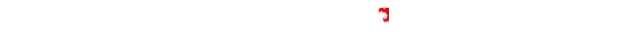

----------------------------


12 7


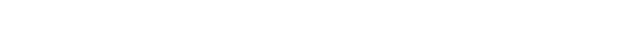

----------------------------


1 825
18 309


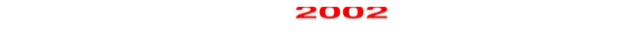

----------------------------


2 21
17 688


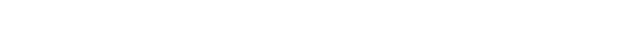

----------------------------


17 823


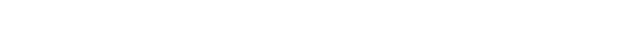

----------------------------


17 822


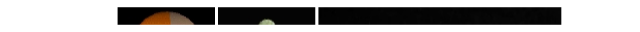

----------------------------


1 10
17 763


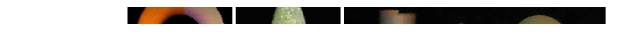

----------------------------


17 601


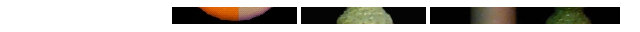

----------------------------


17 215


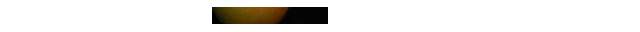

----------------------------


17 825


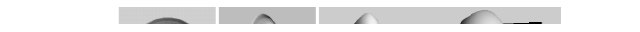

----------------------------


17 822


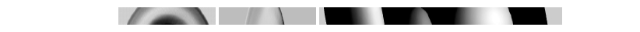

----------------------------


17 823


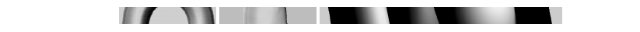

----------------------------


17 822


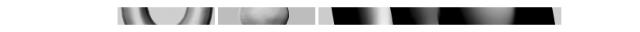

----------------------------


2 2
17 653


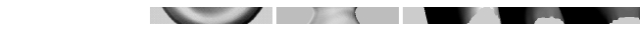

----------------------------


17 204


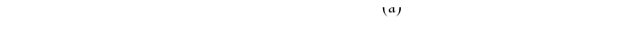

----------------------------


33 215


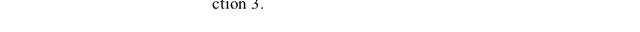

----------------------------


3 1
4 1
4 1
4 1
4 1
40 63


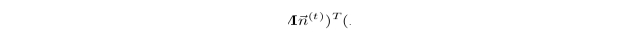

----------------------------


8 45
40 317


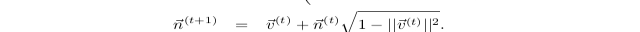

----------------------------


8 44
17 312


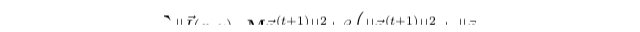

----------------------------


17 823


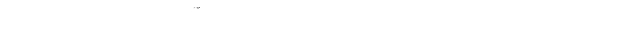

----------------------------


13 165


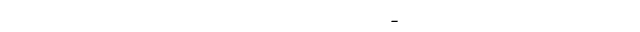

----------------------------


19 482


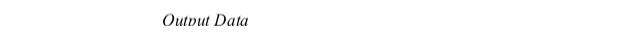

----------------------------


17 595


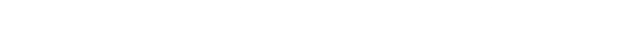

----------------------------


17 597


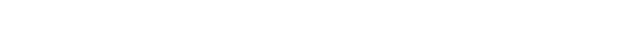

----------------------------


17 598


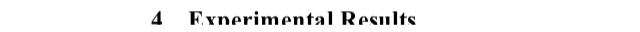

----------------------------


17 593


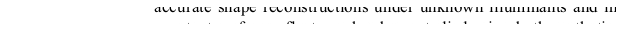

----------------------------


2 51
14 221


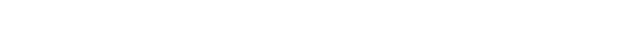

----------------------------


13 220


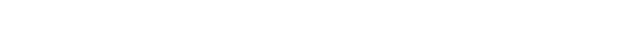

----------------------------


17 221


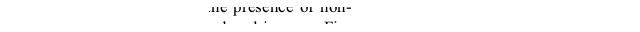

----------------------------


17 823


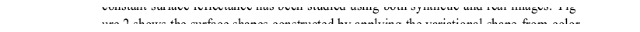

----------------------------


17 825


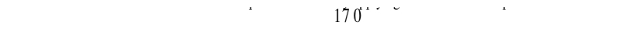

----------------------------


1 825
9 124
8 141


In [ ]:

def just_some_code_to_output_preprocessed_img():
  img = cv2.imread('drive/MyDrive/btp_test/testcases/images/POD_0372.bmp')
  unannotated_lines = do_preprocessing('drive/MyDrive/btp_test/testcases/images/POD_0374.bmp')
  #draw_rectangle(img, unannotated_lines)
  for b in unannotated_lines:
    y, x, _ = np.shape(img[b.y1:b.y2+1, b.x1:b.x2+1]) 
    print(y, x)
    if (y < 12):
      continue
    pros_img = img[b.y1:b.y2+1, b.x1:b.x2+1]
    if (x < 640):
      pros_img = cv2.copyMakeBorder(
                 pros_img,
                 0, 
                 0, 
                 (640-x)//2, 
                 (640-x)//2 + (x%2), 
                 cv2.BORDER_CONSTANT, 
                 value= [255, 255, 255]
              )
    
    if (y < 32):
      pros_img = cv2.copyMakeBorder(
                 pros_img, 
                 (32-y)//2, 
                 (32-y)//2 + (x%2), 
                 0,
                 0,
                 cv2.BORDER_CONSTANT, 
                 value= [255, 255, 255]
              )
    
if (TESTING):
  just_some_code_to_output_preprocessed_img()

In [ ]:
#Dataset Preparation
def prepare_dataset():

  if TESTING:
    image_folder_path = testing_image_folder_path
    annotation_folder_path = testing_annotation_folder_path
    prepared_annotation_folder_path = testing_prepared_annotation_folder_path
  else:
    image_folder_path = train_image_folder_path
    annotation_folder_path = train_annotation_folder_path
    prepared_annotation_folder_path = train_prepared_annotation_folder_path

    file_list = os.listdir(image_folder_path)
    number_of_files = len(file_list)

  with tqdm(total=number_of_files) as pbar:

    for image_filename in file_list:

      annotation_filename = image_filename[:-3]+'xml'

      unannotated_lines = do_preprocessing(image_folder_path+image_filename)
      preannotated_lines = extract_annotations_for_img(annotation_folder_path+annotation_filename)

      preannotated_lines_added = []
      final_processed_lines = []

      for unano_line in unannotated_lines:
        something_added = False
        for anno_line in preannotated_lines:
          if (do_blocks_outline_same_thing(anno_line, unano_line)):
            if (not(anno_line in preannotated_lines_added)):
              final_processed_lines.append(anno_line)
              preannotated_lines_added.append(anno_line)
            something_added = True
        if not something_added:
          final_processed_lines.append(unano_line)

        data = {}
        data['lines'] = []
        for line in final_processed_lines:
          data['lines'].append(
              {
                  'x1': int(line.x1),
                  'y1': int(line.y1),
                  'x2': int(line.x2),
                  'y2': int(line.y2),
                  'block_class': line.block_class
              }
          )

        json_file = prepared_annotation_folder_path + image_filename[:-3]+'json'
        with open(json_file, 'w') as outfile:
            json.dump(data, outfile)

      if (TESTING):
        print(image_filename)
        print(image_folder_path+image_filename)
        img = cv2.imread(image_folder_path+image_filename)
        cv2_imshow(img)
        # draw_rectangle(img, final_processed_lines)
        print(output)
      
      pbar.update(1)



In [ ]:
# Uncomment only if TESTING is set to TRUE.
# prepare_dataset()